# 整体步骤
1. 对于小样本数据，倾向于传统统计方法
2. 趋势预测
3. 样本量过小：前期历史参考数据进行拟合--插值拟合或者指数拟合
4. 插值拟合的点不具备业务意义
5. 未来数据预测：ARIMA模型

# 需要输入的参数

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# 需要week0-week13的指标数据
# 近100天的数据

retention_rates = [1.0000, 0.7594, 0.6482, 0.5834, 0.5376, 0.4946, 0.4662, 0.4387, 0.4153, 0.3969, 0.3748, 0.3571, 0.3404, 0.3283, 0.3114, 0.2993, 0.2843, 0.2766, 0.2647, 0.2527, 0.2438, 0.2374, 0.2299, 0.2229]

conversion_rates = [0.0150, 0.0187, 0.0205, 0.0217, 0.0224, 0.0230, 0.0234, 0.0238, 0.0241, 0.0243, 0.0245, 0.0247, 0.0248, 0.0250, 0.0251, 0.0253, 0.0254, 0.0255, 0.0256, 0.0257, 0.0258, 0.0259, 0.0260, 0.0260]
paypay_rates = [1.0000, 0.6803, 0.5881, 0.5275, 0.4809, 0.4555, 0.4431, 0.4203, 0.4002, 0.3827, 0.3760, 0.3541, 0.3477, 0.3372, 0.3312, 0.3136, 0.3026, 0.2930, 0.2994, 0.2999, 0.2994, 0.2935, 0.2950, 0.2967]
arppu = [20.71, 26.43, 26.53, 26.47, 26.21, 26.23, 25.49, 25.60, 25.85, 25.32, 24.77, 25.88, 24.18, 24.43, 24.92, 25.05, 24.30, 24.26, 23.41, 22.85, 23.61, 22.42, 24.07, 24.38]

# retention_rates = [x * 100 for x in retention_rates]
# conversion_rates = [x * 100 for x in conversion_rates]
# paypay_rates = [x * 100 for x in paypay_rates]


factor_dict = {"pay_rention": retention_rates, "cum_conversion": conversion_rates, "payer_pay": paypay_rates, "ARPPU": arppu}

# 观测周期
weeks_observed = len(retention_rates)
days_observed = []
for i in range(weeks_observed):
    days_observed.append(i*7+6)
    
print(days_observed) 

# 需要预测的时间范围
# 确定预测周期
weeks_predicted = 30
forecast_days = np.arange(days_observed[-1]+1, days_observed[-1]+weeks_predicted*7+1)
forecast_weeks = forecast_days[6::7]
fcat_peroids = len(forecast_days)
print(forecast_weeks, fcat_peroids)



[6, 13, 20, 27, 34, 41, 48, 55, 62, 69, 76, 83, 90, 97, 104, 111, 118, 125, 132, 139, 146, 153, 160, 167]
[174 181 188 195 202 209 216 223 230 237 244 251 258 265 272 279 286 293
 300 307 314 321 328 335 342 349 356 363 370 377] 210


# 导入原始数据

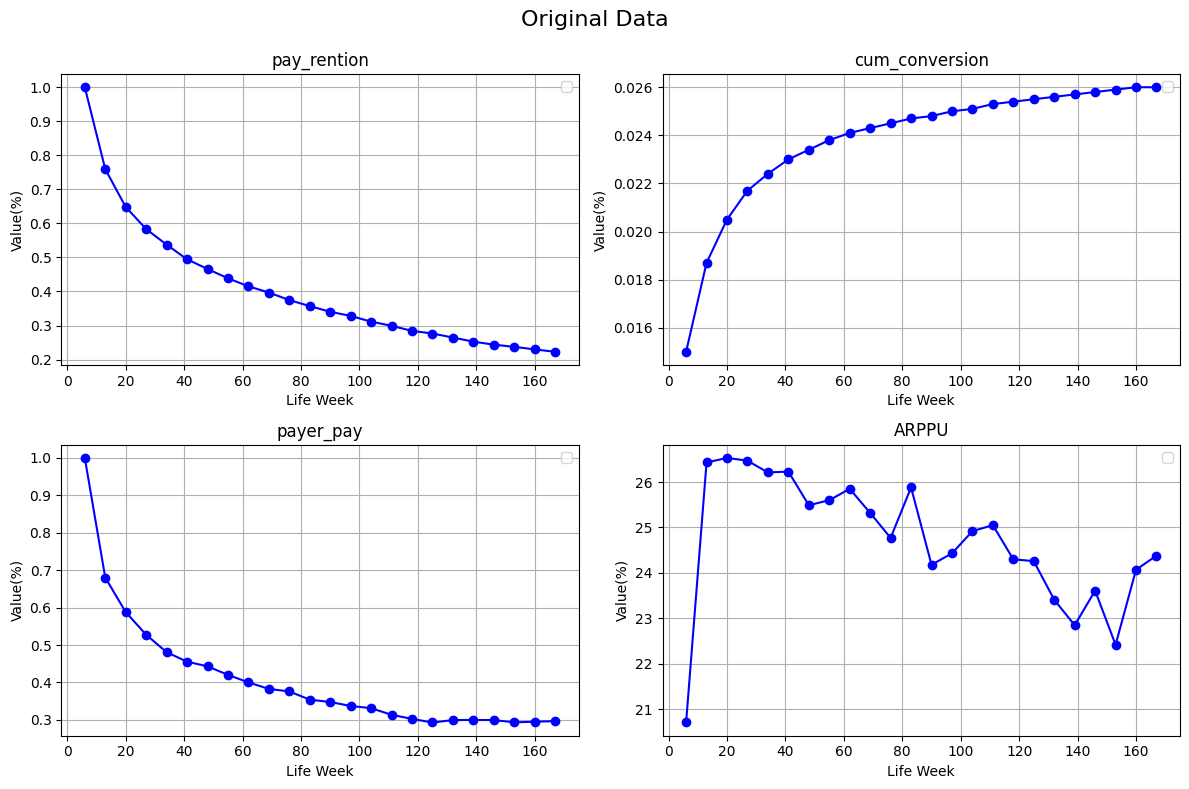

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Original Data", fontsize=16)
axs = axs.flatten()  # 展平二维子图数组为一维，才能按序号索引
for i, (name, factor) in enumerate(factor_dict.items()):
    # 绘制序列
    axs[i].plot(pd.Series(days_observed), pd.Series(factor), 
               color='blue', marker='o')
    
    axs[i].set_xlabel("Life Week")
    axs[i].set_ylabel("Value(%)")
    axs[i].set_title(name)
    axs[i].grid(True)
    axs[i].legend()

# 调整子图间距
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 为总标题留出空间
plt.show()


# 平滑插值拟合，获取更多样本

[0.91716118 0.80072044 0.70455441 0.62513284 0.5595402  0.50536857
 0.46062933 0.4236801  0.39316449 0.36796227 0.34714828 0.32995842
 0.31576167 0.30403686 0.29435358 0.28635636 0.27975162 0.2742969
 0.26979195 0.26607141 0.26299869 0.260461   0.25836517 0.25663426]


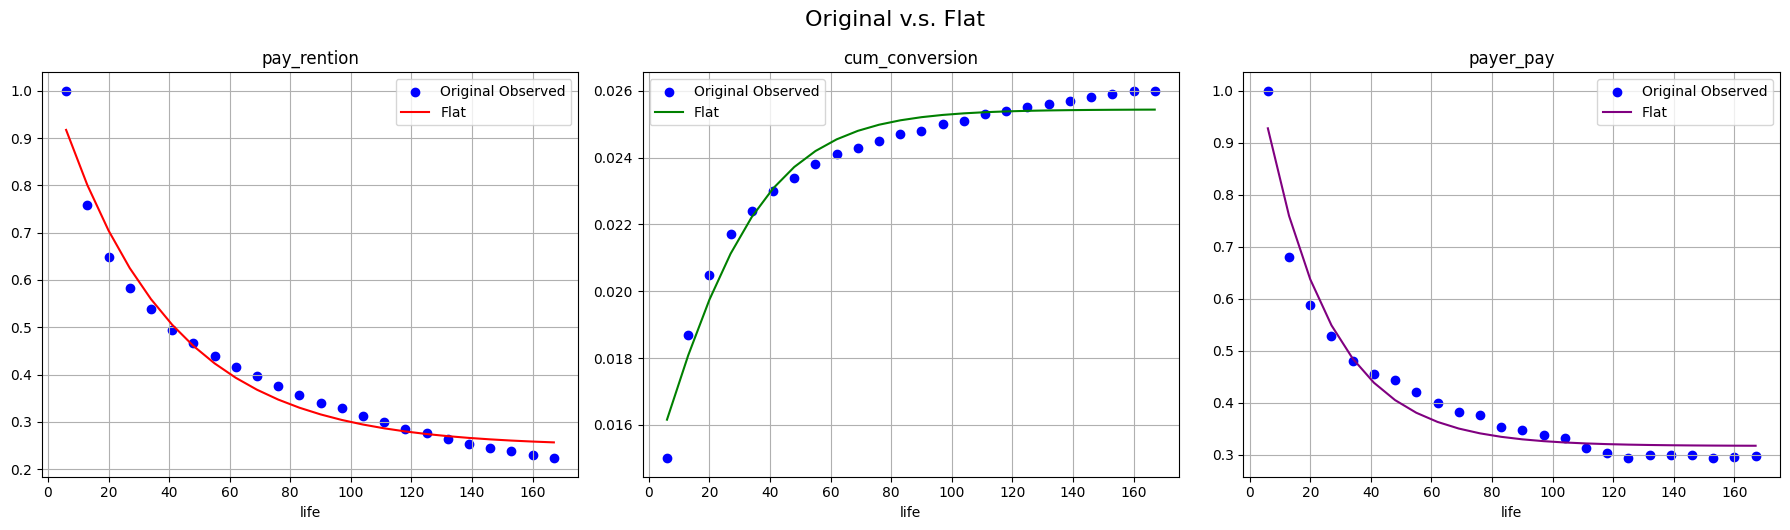

In [20]:
# 拟合插值：构建 D1~D30 每日数据
# from scipy.interpolate import CubicSpline
# interp_days = np.arange(6, 56)
# cs = CubicSpline(days_observed, retention_rates)
# retention_interp = cs(interp_days)

# 指数拟合
from scipy.optimize import curve_fit

# 获取显示表达
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Logistic 函数
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

params1, _ = curve_fit(exp_decay, days_observed, retention_rates, p0=(50, 0.05, 25))
params2, _ = curve_fit(logistic, days_observed, conversion_rates, p0=(15, 0.2, 5))
params3, _ = curve_fit(exp_decay, days_observed, paypay_rates, p0=(50, 0.05, 25))
a, b, c = params1
L, k, x0 = params2
a3, b3, c3 = params3
# print(f"拟合参数：a={a:.3f}, b={b:.4f}, c={c:.3f}")
# print(f"拟合参数：a={L:.3f}, b={b:.4f}, c={c:.3f}")
x_fit = np.array(days_observed)

# 获取值 按照day维度拟合
y_fit1 = exp_decay(x_fit, *params1)
y_fit2 = logistic(x_fit, *params2)
y_fit3 = exp_decay(x_fit, *params3)
print(y_fit1)

# 创建三张子图
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# 图1：指数拟合1
axs[0].scatter(days_observed, retention_rates, color='blue', label='Original Observed')
axs[0].plot(x_fit, y_fit1, color='red', label='Flat')
axs[0].set_title("pay_rention")
axs[0].set_xlabel("life")
# axs[0].set_ylabel("留存率 (%)")
axs[0].grid(True)
axs[0].legend()

# 图2：Logistic 拟合
axs[1].scatter(days_observed, conversion_rates, color='blue', label='Original Observed')
axs[1].plot(x_fit, y_fit2, color='green', label='Flat')
axs[1].set_title("cum_conversion")
axs[1].set_xlabel("life")
axs[1].grid(True)
axs[1].legend()

# 图3：指数拟合2
axs[2].scatter(days_observed, paypay_rates, color='blue', label='Original Observed')
axs[2].plot(x_fit, y_fit3, color='purple', label='Flat')
axs[2].set_title("payer_pay")
axs[2].set_xlabel("life")
axs[2].grid(True)
axs[2].legend()

# 整体布局优化
plt.tight_layout()
plt.suptitle("Original v.s. Flat", fontsize=16, y=1.05)
plt.show()

# ARIMA模型之前的检验--平稳性检验

In [14]:
# p值<0.05 拒绝原假设 原序列平稳
from statsmodels.tsa.stattools import adfuller
ts = pd.Series(arppu)
result = adfuller(ts)
print("ADF p-value:", result[1])

ADF p-value: 0.4591180418355235


# 滚动预测

In [ ]:
from pmdarima import auto_arima
from scipy.special import logit, expit

def roll_arima(y, log=True, dec=True, steps=1, trace_param=False):
    # y为原始时间序列数据
    # logit为是否进行log变换
    # dec为是否保持单调递减的性质
    # 默认预测步长为7

    # 建立deep copy
    # y = y_org.copy()
    if log:
        y_logit = logit(np.clip(y, 1e-6, 1 - 1e-6))
        if dec:
            auto_model = auto_arima(y_logit, d=1, seasonal=False, trace=trace_param)
            forecast_logit, conf_int_logit = auto_model.predict(n_periods=steps, return_conf_int=True)
            forecast = expit(forecast_logit)
            conf_int = expit(conf_int_logit)
        else:
            auto_model = auto_arima(y_logit, trend='t', seasonal=False, trace=trace_param)
            forecast_logit, conf_int_logit = auto_model.predict(n_periods=steps, return_conf_int=True)
            forecast = expit(forecast_logit)
            conf_int = expit(conf_int_logit)
            # 保持单调递增
            forecast = np.maximum.accumulate(forecast)
    else:
        y_logit = y
        auto_model = auto_arima(y_logit, seasonal=False, trace=trace_param)
        forecast, conf_int = auto_model.predict(n_periods=steps, return_conf_int=True)

    # 预测完成后，将预测数据加入到原始时间序列数据集中
    # 实现滚动预测
   
    return forecast
    
    
    

In [ ]:
y_fit = [y_fit1, y_fit2, y_fit3, arppu]
y_original = [retention_rates, conversion_rates, paypay_rates, arppu]

logit_params = [True, True, True, False]
dec_params = [True, False, True, False]
pre_list = []
for y, a1, a2 in zip(y_fit, logit_params, dec_params):
    pre = []
    y_copy = y.copy()
    for i in range(weeks_predicted):
        result = roll_arima(y_copy, a1, a2)
        # 只保留最后一个结果
        pre.append(result[-1])
        # print(result)

        # 滚动预测
        y_copy = np.append(y_copy, result)  # 自动完成所有操作，一步到位
        # print(y_copy)


    pre_list.append(pre)

print(pre_list)

# 根据AIC/BIC选择最优参数
* 越小越好

In [21]:
from pmdarima import auto_arima
from scipy.special import logit, expit

# 利用log变换
y_logit1 = logit(np.clip(retention_rates, 1e-6, 1 - 1e-6))
y_logit2 = logit(np.clip(conversion_rates, 1e-6, 1 - 1e-6))
y_logit3 = logit(np.clip(paypay_rates, 1e-6, 1 - 1e-6))
# y_logit1 = y_fit1
# y_logit2 = y_fit2
# y_logit3 = y_fit3
auto_model1 = auto_arima(y_logit1, d=1, seasonal=False, trace=True)
auto_model2 = auto_arima(y_logit2, trend='t', seasonal=False, trace=True)
auto_model3 = auto_arima(y_logit3, d=1, seasonal=False, trace=True)
auto_model4 = auto_arima(arppu, seasonal=False, trace=True)
# print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.565, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=114.100, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.186, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.020, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=116.077, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.461 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-81.130, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-88.679, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-97.313, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-90.761, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-88.679, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-93.888, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-77.153, Time=0.14 

# ARIMA预测和拟合直接预测对比

[array([0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229,
       0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229,
       0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229,
       0.2229, 0.2229, 0.2229, 0.2229, 0.2229, 0.2229]), array([0.02591036, 0.02574049, 0.02549883, 0.02519294, 0.02482959,
       0.02441479, 0.02395396, 0.02345195, 0.02291318, 0.02234167,
       0.02174114, 0.02111506, 0.02046669, 0.01979912, 0.01911533,
       0.01841819, 0.01771047, 0.01699489, 0.01627409, 0.01555068,
       0.01482717, 0.01410603, 0.01338966, 0.01268038, 0.01198043,
       0.01129192, 0.0106169 , 0.00995724, 0.00931472, 0.00869096]), array([0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967,
       0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967,
       0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967,
       0.2967, 0.2967, 0.2967, 0.2967, 0.2967, 0.2967]), array([24.45922119, 24.50013749, 24.52127   , 24.532184

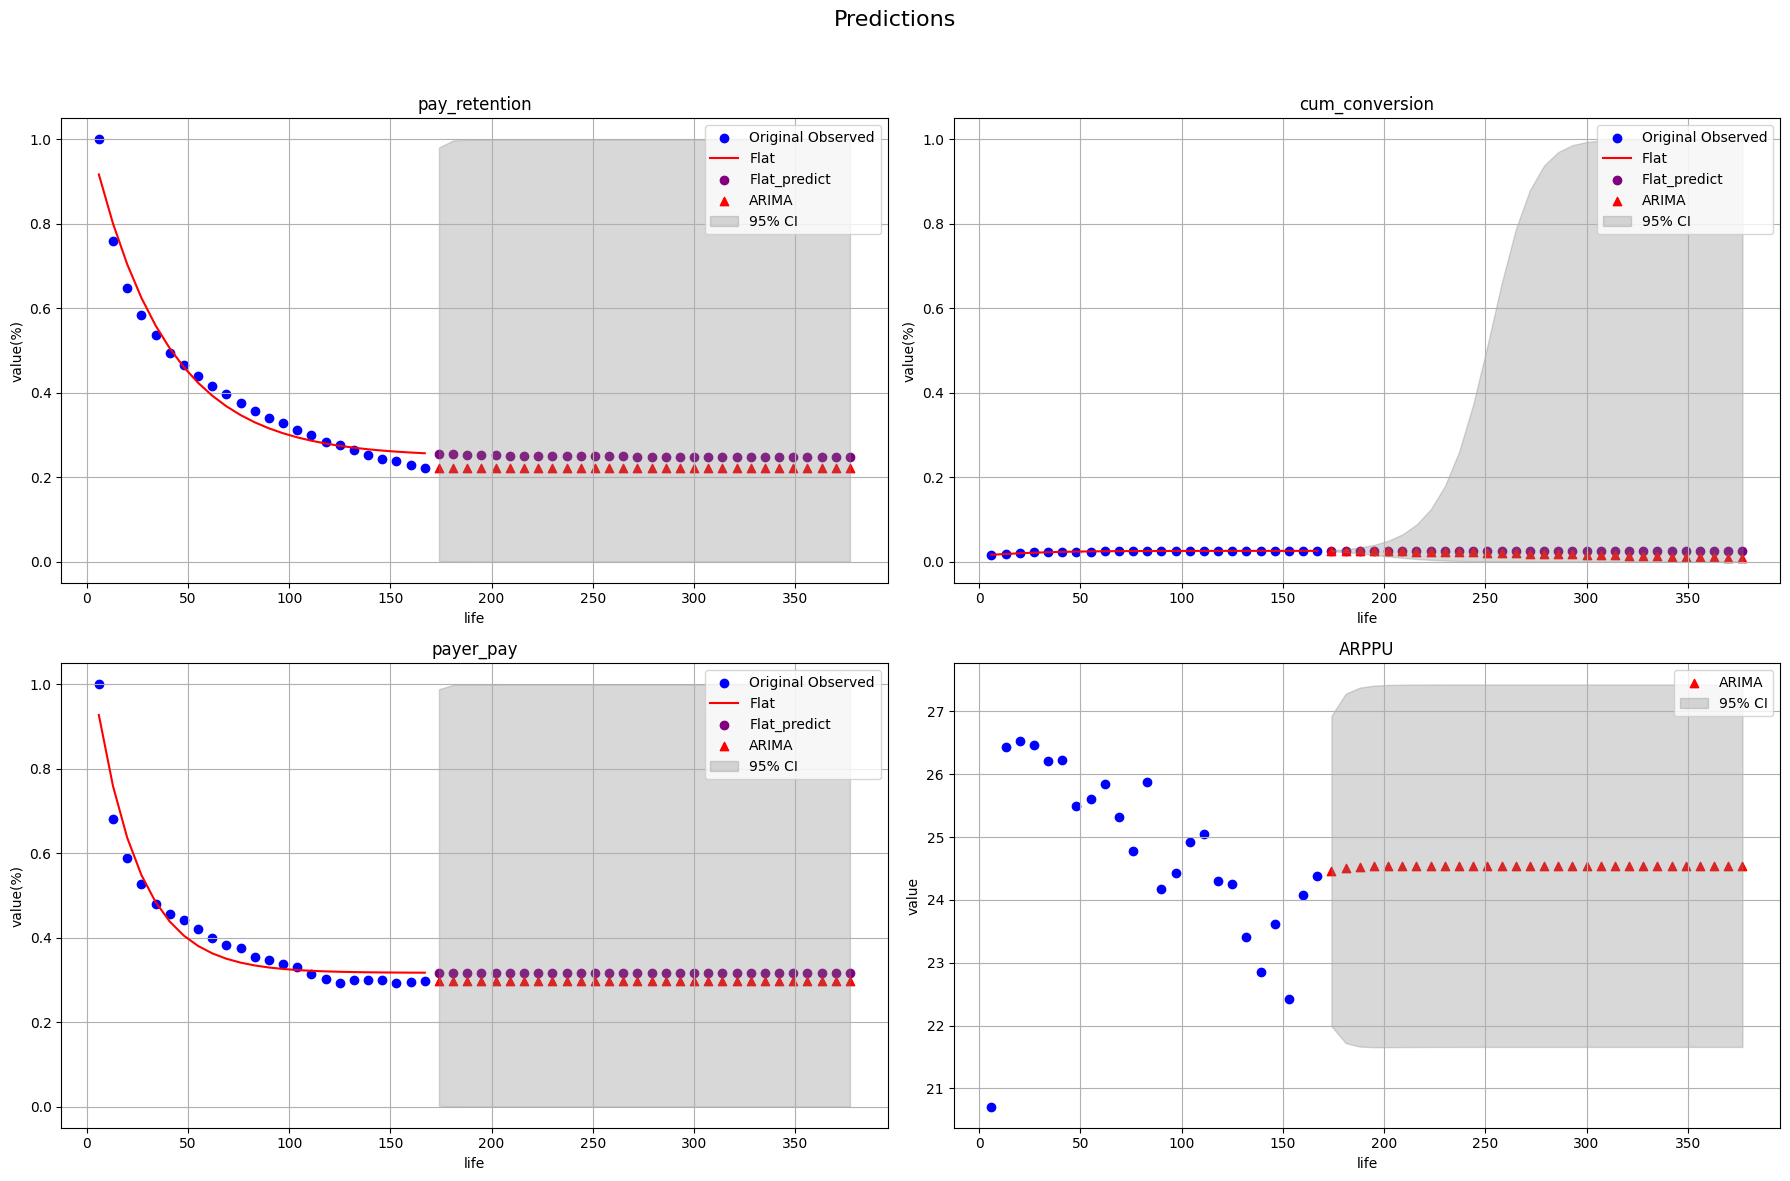

In [22]:


# 拟合 ARIMA 模型（示例使用 (1,1,0)，你可用 AIC/BIC 精调）
# 精调后的结果
# model = ARIMA(y_fit, order=(2, 2, 1))  # (p,d,q)
# fitted_model = model.fit()

# 返回预测区间--95%
forecast1_logit, conf_int1_logit = auto_model1.predict(n_periods=weeks_predicted, return_conf_int=True)
forecast1 = expit(forecast1_logit)
conf_int1 = expit(conf_int1_logit)
# forecast1 = forecast1_logit
# conf_int1 = conf_int1_logit

forecast2_logit, conf_int2_logit = auto_model2.predict(n_periods=weeks_predicted, return_conf_int=True)
forecast2 = expit(forecast2_logit)
conf_int2 = expit(conf_int2_logit)
# forecast2 = forecast2_logit
# conf_int2 = conf_int2_logit

forecast3_logit, conf_int3_logit = auto_model3.predict(n_periods=weeks_predicted, return_conf_int=True)
forecast3 = expit(forecast3_logit)
conf_int3 = expit(conf_int3_logit)
# forecast3 = forecast3_logit
# conf_int3 = conf_int3_logit

forecast4, conf_int4 = auto_model4.predict(n_periods=weeks_predicted, return_conf_int=True)
forecast = [forecast1, forecast2, forecast3, forecast4]
print(forecast)
conf_interval = [conf_int1, conf_int2, conf_int3, conf_int4]

# 平滑拟合值
curvefit = [exp_decay(forecast_weeks, *params1), logistic(forecast_weeks, *params2), exp_decay(forecast_weeks, *params3), [0]*weeks_predicted]
print(curvefit)

for i, (fcast, conf, curve) in enumerate(zip(forecast, conf_interval, curvefit), 1):
    print(f"模型{i}：")
    for idx in range(21):
    #     # idx = week * 7 - 1  # 第7、14、21...天，对应索引6、13、20...
        week_val = fcast[idx]
        week_low, week_high = conf[idx]
        week_fit = curve[idx]
        print(f"  后续{idx}周预测 = {week_val:.4f}，区间 = [{week_low:.4f}, {week_high:.4f}]，平滑拟合 = {week_fit:.4f}")
# 创建一个 2x2 的子图网格
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Predictions", fontsize=16)

# 子图 1
axs[0, 0].scatter(days_observed, retention_rates, color='blue', label='Original Observed')
axs[0, 0].plot(x_fit, y_fit1, color='red', label='Flat')
axs[0, 0].scatter(forecast_weeks, exp_decay(forecast_weeks, *params1), marker='o', color='purple', label='Flat_predict')
axs[0, 0].scatter(forecast_weeks, forecast1, marker='^', color='red', label='ARIMA')
axs[0, 0].fill_between(forecast_weeks, conf_int1[:, 0], conf_int1[:, 1], color='gray', alpha=0.3, label='95% CI')
axs[0, 0].set_title("pay_retention")
axs[0, 0].set_xlabel("life")
axs[0, 0].set_ylabel("value(%)")
axs[0, 0].grid(True)
axs[0, 0].legend()


# 子图 2
axs[0, 1].scatter(days_observed, conversion_rates, color='blue', label='Original Observed')
axs[0, 1].plot(x_fit, y_fit2, color='red', label='Flat')
axs[0, 1].scatter(forecast_weeks, logistic(forecast_weeks, *params2), marker='o', color='purple', label='Flat_predict')
axs[0, 1].scatter(forecast_weeks, forecast2, marker='^', color='red', label='ARIMA')
axs[0, 1].fill_between(forecast_weeks, conf_int2[:, 0], conf_int2[:, 1], color='gray', alpha=0.3, label='95% CI')
axs[0, 1].set_title("cum_conversion")
axs[0, 1].set_xlabel("life")
axs[0, 1].set_ylabel("value(%)")
axs[0, 1].grid(True)
axs[0, 1].legend()



# 子图 3
axs[1, 0].scatter(days_observed, paypay_rates, color='blue', label='Original Observed')
axs[1, 0].plot(x_fit, y_fit3, color='red', label='Flat')
axs[1, 0].scatter(forecast_weeks, exp_decay(forecast_weeks, *params3), marker='o', color='purple', label='Flat_predict')
axs[1, 0].scatter(forecast_weeks, forecast3, marker='^', color='red', label='ARIMA')
axs[1, 0].fill_between(forecast_weeks, conf_int3[:, 0], conf_int3[:, 1], color='gray', alpha=0.3, label='95% CI')
axs[1, 0].set_title("payer_pay")
axs[1, 0].set_xlabel("life")
axs[1, 0].set_ylabel("value(%)")
axs[1, 0].grid(True)
axs[1, 0].legend()

# 子图 4
axs[1, 1].scatter(days_observed, arppu, marker='o', color='blue')
axs[1, 1].scatter(forecast_weeks, forecast4, marker='^', color='red', label='ARIMA')
axs[1, 1].fill_between(forecast_weeks, conf_int4[:, 0], conf_int4[:, 1], color='gray', alpha=0.3, label='95% CI')
axs[1, 1].set_title("ARPPU")
axs[1, 1].set_xlabel("life")
axs[1, 1].set_ylabel("value")
axs[1, 1].grid(True)
axs[1, 1].legend()

# 自动调整布局
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出标题空间
plt.show()